In [ ]:
team members = "Aidos Utebayev, Ayhan Garayev"

In [162]:
import pandas as pd


### Find the components of SP500

In [163]:
file = pd.read_excel("sp500_composition.xlsx")
file.head()

,Date,Year,Company Name,Ticker
0,2019-12-31,2019,COLGATE PALMOLIVE CO,CL
1,2019-12-31,2019,ZIMMER BIOMET HOLDINGS INC,ZBH
2,2019-12-31,2019,CITRIX SYSTEMS INC,CTXS
3,2019-12-31,2019,DOW INC,DOW
4,2019-12-31,2019,AMCOR PLC,AMCR


In [164]:
file_2019 = file[file["Year"]==2019]["Ticker"].to_list()
file_2020 = file[file["Year"]==2020]["Ticker"].to_list()
file_2021 = file[file["Year"]==2021]["Ticker"].to_list()
file_2022 = file[file["Year"]==2022]["Ticker"].to_list()
file_2023 = file[file["Year"]==2023]["Ticker"].to_list()
company_dict = [{"year": 2019, "start": "2019-01-01", "end":"2019-12-31", "tickers": file_2019}, 
                {"year": 2020, "start": "2020-01-01", "end":"2020-12-31", "tickers": file_2020}, 
               {"year": 2021, "start": "2021-01-01", "end":"2021-12-31", "tickers": file_2021}, 
               {"year": 2022, "start": "2022-01-01", "end":"2022-12-31", "tickers": file_2022}, 
               {"year": 2023, "start": "2023-01-01", "end":"2023-12-31", "tickers": file_2023}]

In [165]:
company_dict[0].keys()

dict_keys(['year', 'start', 'end', 'tickers'])

### Download SP500 components' 10-K file

In [ ]:
import os
from sec_edgar_downloader import Downloader

custom_directory = "/Users/aidosutebayev/Documents/NYU/7871NLP/SEC_Filings"

dl = Downloader("NYU", "au2258@nyu.edu", custom_directory)

file_type = "10-K"
failed_files = []
companies = 0

for file in company_dict:
    print(f'10-K for: {file["year"]}')
    for ticker in file["tickers"]:
        try:
            dl.get(file_type, ticker, after=file["start"], before=file["end"])
            companies+=1
        except Exception as e:
            print(f"Failed to download {file_type} for {ticker}: {e}")
            failed_files.append(ticker)
            companies+=1

In [ ]:
len(failed_files)

### Read & parse 10-K files

In [1]:
def Find_all_freq(tokens,all_word,stopword):
    
    # all words in file content 
    freq_all = Counter(tokens)
    
    # delete words that are not in lm_dictionary and words in stopwords and not in stopwords
    filtered_word = list(set(tokens) & set(all_word) - set(stopword))
    freq_all_filtered = {key: value for key, value in freq_all.items() if key in filtered_word}
    
    return freq_all_filtered

In [2]:
def Find_neg_freq(tokens,freq_all_filtered,negative_list,all_lm_word, stopword):
    filtered_word = list(set(tokens) & set(all_lm_word) - set(stopword))
    neg_filtered_word = list(set(filtered_word) & set(negative_list))
    freq_neg_filtered = {key: value for key, value in freq_all_filtered.items() if key in neg_filtered_word}
    return freq_neg_filtered

def negative_pro(neg,all_word):
    num_neg = sum(neg.values())
    num_all_word = sum(all_word.values())
    neg_pro = num_neg/num_all_word
    return neg_pro

def Matrix1(f_neg,i,matrix):
    matrix1 = matrix.copy()
    mat = pd.DataFrame(f_neg.items(), columns=['neg',str(i)])
    mat = mat.set_index('neg') 
    matrix1 = pd.concat([matrix1, mat],axis=1)
    return matrix1

def Matrix2(matrix):
    matrix2 = matrix.copy()
    matrix2[matrix2>0] = 1
    return matrix2

def Matrix3(num_word_list,freq):
    num_word = sum(freq.values())  
    num_word_list.append(num_word)
    return num_word_list

In [3]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
import os
import pandas as pd

def Main():
    # Specify the root directory
    root_directory = r'/Users/aidosutebayev/Documents/NYU/7871NLP/SEC_Filings/sec-edgar-filings'
    count = 0
    
    nltk.download('stopwords')
    stopword = stopwords.words('english')
    
    # lm
    lm_dictionary = pd.read_csv('/Users/aidosutebayev/Documents/NYU/7871NLP/Dictionary/Loughran-McDonald_MasterDictionary_1993-2023.csv')
    all_lm_word = lm_dictionary['Word'].to_list()
    lm_Negative = lm_dictionary[lm_dictionary['Negative']!=0]
    lm_Negative = lm_Negative['Word'].to_list()
    lm_pro_list = []
    
    # TODO
    # Harvard all words, only neg, all words
    H_Negative = pd.read_csv('/Users/aidosutebayev/Documents/NYU/7871NLP/Harvard_Neg.csv',header=None)
    H_Negative = H_Negative[0].to_list()
    H_pro_list = []
    
    #tfidf
    matrix1 = pd.DataFrame()
    num_word_list = []
    
    #tfidf_H
    matrix1_H = pd.DataFrame()
    
    #basic data
    cik_list = []
    filing_date_list = []
    
    count = 0
    # Iterate through all folders, subfolders, and files using os.walk()
    for folder_path, _, files in os.walk(root_directory):
        for file_name in files:
            # Construct the full path to the file
            file_path = os.path.join(folder_path, file_name)

            # Open and read the file
            with open(file_path, 'r') as file:
                try:
                    # Process the file content as needed
                    file_content = file.read()
                    file_content = file_content.upper()
                    tokens = re.findall('\w+', file_content)


                    # Get basic data
                    idx_key = tokens.index('KEY')
                    cik_list.append(tokens[idx_key+1])
                    filing_date_list.append(tokens[6])


                    # Get target data_lm
                    freq_all = Find_all_freq(tokens,all_lm_word,stopword)
                    freq_neg_lm = Find_neg_freq(tokens,freq_all,lm_Negative,all_lm_word,stopword)

                    # Get target data_H
                    freq_neg_H = Find_neg_freq(tokens,freq_all,H_Negative,all_lm_word, stopword)

                    # normal proportion of negative words_lm
                    lm_pro = negative_pro(freq_neg_lm,freq_all)
                    lm_pro_list.append(lm_pro)

                    # normal proportion of negative words_H
                    H_pro = negative_pro(freq_neg_H,freq_all)
                    H_pro_list.append(H_pro)

                    # build tfidf_lm
                    matrix1 = Matrix1(freq_neg_lm,count,matrix1)
                    num_word_list = Matrix3(num_word_list,freq_all)

                    # build tfidf_H
                    matrix1_H = Matrix1(freq_neg_H,count,matrix1_H)

                    count+=1 

                except:
                    print('empty')
            
    matrix1.fillna(0, inplace=True)
    matrix1_H.fillna(0, inplace=True)
        
    result_list_lm = [matrix1, num_word_list, lm_pro_list,cik_list,filing_date_list]
    result_list_H = [matrix1_H, num_word_list, H_pro_list,cik_list,filing_date_list]
    return result_list_lm, result_list_H

result_list_lm, result_list_H = Main()
result_list_lm.append(Matrix2(result_list_lm[0]))
result_list_H.append(Matrix2(result_list_H[0]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aidosutebayev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty


#### Save results to csv files

In [26]:
result_list_H_0 = result_list_H[0]
result_list_H_1 = pd.Series(result_list_H[1])
result_list_H_2 = pd.Series(result_list_H[2])
result_list_H_3 = pd.Series(result_list_H[3])
result_list_H_5 = result_list_H[5]
result_list_H_4 = pd.Series(result_list_H[4])
result_list_H_1_4 = pd.DataFrame(
    dict(result_list_H_1 = result_list_H_1, 
         result_list_H_2 = result_list_H_2, 
         result_list_H_3=result_list_H_3, 
         result_list_H_4=result_list_H_4)).reset_index()

In [27]:
result_list_lm_0 = result_list_lm[0]
result_list_lm_1 = pd.Series(result_list_lm[1])
result_list_lm_2 = pd.Series(result_list_lm[2])
result_list_lm_3 = pd.Series(result_list_lm[3])
result_list_lm_5 = result_list_lm[5]
result_list_lm_4 = pd.Series(result_list_lm[4])
result_list_lm_1_4 = pd.DataFrame(
    dict(result_list_lm_1 = result_list_lm_1, 
         result_list_lm_2 = result_list_lm_2, 
         result_list_lm_3=result_list_lm_3, 
         result_list_lm_4=result_list_lm_4)).reset_index()

In [30]:
result_list_H_1.to_csv("result_list_H_1.csv")
result_list_H_2.to_csv("result_list_H_2.csv")
result_list_H_3.to_csv("result_list_H_3.csv")
result_list_H_4.to_csv("result_list_H_4.csv")
result_list_lm_1.to_csv("result_list_lm_1.csv")
result_list_lm_2.to_csv("result_list_lm_2.csv")
result_list_lm_3.to_csv("result_list_lm_3.csv")
result_list_lm_4.to_csv("result_list_lm_4.csv")

In [29]:
result_list_H_5.to_csv("result_list_H_5.csv")
result_list_H_0.to_csv("result_list_H_0.csv")
result_list_H_1_4.to_csv("result_list_H_1_4.csv")
result_list_lm_5.to_csv("result_list_lm_5.csv")
result_list_lm_0.to_csv("result_list_lm_0.csv")
result_list_lm_1_4.to_csv("result_list_lm_1_4.csv")

### Calculate excess return

In [3]:
import wrds

In [170]:
conn=wrds.Connection()

Enter your WRDS username [aidosutebayev]:au2258
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [105]:
conn.list_libraries().sort()
list1 = conn.list_libraries()

In [106]:
tables = {}
for lib in list1:
    try:
        tables[lib] = conn.list_tables(library=lib)
    except Exception as e:
        print(f"Couldn't get tables for {lib}")

In [167]:
libraries = []
for table in tables.keys(): 
    for l in tables[table]:
        libraries.append(f"{table}: {l}")
libraries[0]

'aha_sample: annual_survey'

In [108]:
cik_int = tuple(set(result_list_H_3))
len(cik_int)

522

In [172]:
cik = []
for number in cik_int:
    temp_str = ""
    number_str = str(number) 
    length = len(number_str)
    if length<10:
        temp_str = (10-length)*'0' + number_str
    else:
        temp_str = number_str
    cik.append(temp_str)
cik = tuple(set(cik))

In [173]:
sp500 = conn.raw_sql(f"""
                        select *
                        from wrdssec.wciklink_cusip
                        where cik in {cik} and cikdate2>='01/01/2019' and issuer IS NOT NULL;
                        """)
sp500.head()

,cik,coname,cusip_full,cusip,cikdate1,cikdate2,tmatch,issuer,issue,issue_check,validated
0,0000001800,ABBOTT LABORATORIES,002824100,00282410,1994-02-14,2020-02-14,140.0,ABBOTT LABS,COM,0,3.0
1,0000002488,ADVANCED MICRO DEVICES INC,007903107,00790310,1994-02-10,2020-02-12,757.0,ADVANCED MICRO DEVICES INC,COM,7,3.0
2,0000002969,AIR PRODUCTS & CHEMICALS INC /DE/,009158106,00915810,1996-02-12,2022-02-08,493.0,AIR PRODS & CHEMS INC,COM,6,3.0
3,0000004127,SKYWORKS SOLUTIONS INC,83088M102,83088M10,2003-02-10,2024-09-10,446.0,SKYWORKS SOLUTIONS INC,COM,2,3.0
4,0000004281,Arconic Inc,03965L100,03965L10,2016-11-04,2020-05-11,80.0,ARCONIC INC,COM,0,1.0


In [111]:
sp500_cusip = sp500[["cik","cusip"]]
sp500_cusip.drop_duplicates()
sp_cusip = tuple(sp500_cusip['cusip'].unique())
len(sp_cusip)

494

In [112]:
sp500_permno = conn.raw_sql(f"""
                        select DISTINCT cusip, permno
                        from crsp.dsf
                        where cusip in {sp_cusip} and permno is not null;""")

sp500_permno.describe()

,permno
count,466.000000
mean,55881.587983
std,29605.724590
min,10104.000000
25%,23673.000000
50%,61113.500000
75%,84973.250000
max,93436.000000


In [168]:
permno_list = tuple(sp500_permno['permno'])
permno_list[:5]

(14541, 44601, 64995, 13210, 43350)

In [114]:
sp500_returns = conn.raw_sql(f"""
                        select permno, date, ret
                        from crsp.dsf
                        where date>='01/01/2019' and date<='12/31/2023'  and permno in {permno_list}
                        order by date;""")

sp500_returns.head()

,permno,date,ret
0,86580,2019-01-02,0.020375
1,10696,2019-01-02,-0.017417
2,91849,2019-01-02,-0.012156
3,80286,2019-01-02,-0.014501
4,42906,2019-01-02,0.018456


In [115]:
merged_cusip=pd.merge(sp500_cusip[["cik", "cusip"]], sp500_permno[["cusip", "permno"]], on='cusip', how='inner')
merged_cusip.head()

,cik,cusip,permno
0,0000001800,00282410,20482
1,0000002488,00790310,61241
2,0000002969,00915810,28222
3,0000004127,83088M10,45911
4,0000004447,42809H10,28484


In [116]:
merged_cusip=merged_cusip[["cik","permno"]].drop_duplicates(subset=['cik']).dropna()

In [117]:
final_data=pd.merge(merged_cusip, sp500_returns, on='permno', how='inner').dropna()
final_data=final_data[['cik', 'permno', 'date', 'ret']]
final_data.head()

,cik,permno,date,ret
0,0000001800,20482,2019-01-02,-0.039126
1,0000001800,20482,2019-01-03,-0.047194
2,0000001800,20482,2019-01-04,0.028541
3,0000001800,20482,2019-01-07,0.014976
4,0000001800,20482,2019-01-08,-0.012006


In [118]:
final_data.isnull().sum()

cik       0
permno    0
date      0
ret       0
dtype: int64

In [119]:
sp500_index_return = conn.raw_sql("""
    SELECT caldt, sprtrn
    FROM crsp.dsp500
    WHERE caldt >= '2019-01-01' AND caldt <= '2023-12-31'
""")

In [120]:
sp500_index_return.rename(columns={'caldt':"date"}, inplace=True)
sp500_index_return.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1258 non-null   object 
 1   sprtrn  1258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [121]:
sp500_index_return['date']=pd.to_datetime(sp500_index_return['date'])
final_data['date']=pd.to_datetime(final_data['date'])

In [122]:
merged_data = pd.merge(final_data, sp500_index_return, on='date', how='left')
merged_data.head()

,cik,permno,date,ret,sprtrn
0,0000001800,20482,2019-01-02,-0.039126,0.001269
1,0000001800,20482,2019-01-03,-0.047194,-0.024757
2,0000001800,20482,2019-01-04,0.028541,0.034336
3,0000001800,20482,2019-01-07,0.014976,0.007010
4,0000001800,20482,2019-01-08,-0.012006,0.009695


In [123]:
import statsmodels.api as sm

df=pd.read_csv('result_list_lm_1_4.csv')
df.drop(columns=["Unnamed: 0", "index"], inplace=True)
df['filing_date']=pd.to_datetime(df['result_list_lm_4'], format='%Y%m%d')
merged_data['date']=pd.to_datetime(merged_data['date'])
df.head()

,result_list_lm_1,result_list_lm_2,result_list_lm_3,result_list_lm_4,filing_date
0,817497,0.003858,723254,20220727,2022-07-27
1,761585,0.003744,723254,20230727,2023-07-27
2,1884712,0.001535,723254,20190726,2019-07-26
3,784237,0.004049,723254,20210728,2021-07-28
4,1078418,0.003265,723254,20200729,2020-07-29


In [124]:
merged_data['cik'] = merged_data['cik'].astype('int32')
merged_data.head()

,cik,permno,date,ret,sprtrn
0,1800,20482,2019-01-02,-0.039126,0.001269
1,1800,20482,2019-01-03,-0.047194,-0.024757
2,1800,20482,2019-01-04,0.028541,0.034336
3,1800,20482,2019-01-07,0.014976,0.007010
4,1800,20482,2019-01-08,-0.012006,0.009695


In [125]:
beta_list=[]
for _, row in df.iterrows():
  cik=row['result_list_lm_3']
  filing_date=row['filing_date']
  regression_window=merged_data[(merged_data['cik']==cik)&(merged_data['date']>=filing_date-pd.Timedelta(days=90))&(merged_data['date']<filing_date)]

  if not regression_window.empty:
    X=regression_window['sprtrn']
    X=sm.add_constant(X)
    Y=regression_window['ret']
    model=sm.OLS(Y, X).fit()
    if 'const' in model.params:
      alpha=model.params['const']
    else:
      alpha=0
    beta=model.params['sprtrn']

    beta_list.append({'cik':cik, 'filing_date': filing_date, 'beta': beta, 'alpha': alpha})
beta_df=pd.DataFrame(beta_list)
beta_df.head()

,cik,filing_date,beta,alpha
0,723254,2022-07-27,0.996820,0.001022
1,723254,2023-07-27,0.770001,0.001046
2,723254,2019-07-26,0.644778,0.002841
3,723254,2021-07-28,1.283750,0.000981
4,723254,2020-07-29,1.294558,0.002276


In [144]:
trading_dates = merged_data['date'].drop_duplicates().sort_values().tolist()

def get_next_trading_days(filing_date, trading_dates, num_days=4):
    if filing_date not in trading_dates:
        filing_date = min([date for date in trading_dates if date > filing_date])
    filing_idx = trading_dates.index(filing_date)
    return trading_dates[filing_idx: filing_idx + num_days]

excess_returns_avg_list = []

for _, row in beta_df.iterrows():
    cik = row['cik']
    filing_date = row['filing_date']
    beta = row['beta']

    next_4_trading_days = get_next_trading_days(filing_date, trading_dates, num_days=4)

    post_filing_window = merged_data[(merged_data['cik'] == cik) &
                                     (merged_data['date'].isin(next_4_trading_days))].copy()


    if not post_filing_window.empty:
        post_filing_window['excess_return'] = post_filing_window.apply(
            lambda row: row['ret'] - beta * row['sprtrn'], axis=1
        )

        avg_excess_return = post_filing_window['excess_return'].median()

        excess_returns_avg_list.append({
            'cik': cik,
            'filing_date': filing_date,
            'avg_excess_return': avg_excess_return
        })

average_excess_returns_df = pd.DataFrame(excess_returns_avg_list)

print("Average Excess Returns:")
average_excess_returns_df.head()

Average Excess Returns:


,cik,filing_date,avg_excess_return
0,723254,2022-07-27,0.000866
1,723254,2023-07-27,-0.006859
2,723254,2019-07-26,-0.001674
3,723254,2021-07-28,0.002909
4,723254,2020-07-29,-0.008962


In [145]:
average_excess_returns_df.to_csv('average_excess_returns.csv', index=False)

### Get proportion result of LM & Harvard Dictionary

In [146]:
sp500_excessrtn = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/average_excess_returns.csv')
result_list_H_0 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_0.csv')
result_list_H_1 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_1.csv')
result_list_H_2 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_2.csv')
result_list_H_3 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_3.csv')
result_list_H_4 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_4.csv')
result_list_H_5 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_H_5.csv')

In [147]:
result_list_H_0.drop(columns="neg", inplace=True)

In [148]:
result_list_H_5.drop(columns="neg", inplace=True)

In [149]:
result_list_H_1=result_list_H_1['0'].to_list()
result_list_H_2=result_list_H_2['0'].to_list()
result_list_H_3=result_list_H_3['0'].to_list()
result_list_H_4=result_list_H_4['0'].to_list()

In [150]:
result_list_lm_0 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_0.csv')
result_list_lm_1 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_1.csv')
result_list_lm_2 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_2.csv')
result_list_lm_3 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_3.csv')
result_list_lm_4 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_4.csv')
result_list_lm_5 = pd.read_csv('/Users/aidosutebayev/Desktop/NYU/result_list_lm_5.csv')


In [151]:
result_list_lm_0.drop(columns="neg", inplace=True)


In [152]:
result_list_lm_5.drop(columns="neg", inplace=True)

In [153]:
result_list_lm_1=result_list_lm_1['0'].to_list()
result_list_lm_2=result_list_lm_2['0'].to_list()
result_list_lm_3=result_list_lm_3['0'].to_list()
result_list_lm_4=result_list_lm_4['0'].to_list()

In [155]:

mat1 = result_list_lm_0.to_numpy()
mat2 = result_list_lm_5.to_numpy()
mat3 = result_list_lm_1
N = len(mat1[0])
df = mat2.sum(axis=1)

import numpy as np
from numpy import inf
part1 = 1+np.log(mat1)
part2 = 1+np.log(mat3)
part3 = np.log(N/df)

part1[np.isneginf(part1)] = 0
part2[np.isneginf(part2)] = 0
part3[np.isneginf(part3)] = 0

part3 = part3[:,np.newaxis]
#part3 = part3.T
#part1 = part1.T
tfidf = np.divide(part1,part2)*part3
result_tfidf = tfidf.sum(axis=0)
result_LM = pd.DataFrame(list(zip(result_tfidf,result_list_lm_2, result_list_lm_3)),
columns =['tfidf','proportion', 'cik_list'])

date = result_list_lm_4
fdate = []
for i in range(len(date)):
    year = str(date[i])[0:4]
    month = str(date[i])[4:6]
    day = str(date[i])[6:8]
    fdate.append(year+'-'+month+'-'+day)
result_LM['filing_date'] = fdate

# result_LM['filing_date'] = pd.to_datetime(result_LM['filing_date'])
# result_LM['filing_date'] = result_LM['filing_date'].dt.strftime("%Y-%m-%d")
result_LM['cik_list'] = result_LM['cik_list'].astype(str).str.lstrip('0')
result_LM['cik_list'] = result_LM['cik_list'].astype(int)
result_LM = result_LM.rename(columns={'filing_date': 'filing_date','cik_list':'cik'})

result_LM = pd.merge(result_LM,sp500_excessrtn, on=['cik', 'filing_date'],how = 'inner')
# Specify the columns you want to keep in the final DataFrame
result_LM = result_LM[['tfidf','proportion','cik', 'filing_date','avg_excess_return']]  # Replace with your desired column names

/var/folders/9x/srv3h8gx32z9h7gqd2pbh94m0000gn/T/ipykernel_50120/3159629820.py:9: RuntimeWarning: divide by zero encountered in log
  part1 = 1+np.log(mat1)


In [156]:
result_LM

,tfidf,proportion,cik,filing_date,avg_excess_return
0,10.493443,0.003858,723254,2022-07-27,0.000866
1,10.367624,0.003744,723254,2023-07-27,-0.006859
2,6.890714,0.001535,723254,2019-07-26,-0.001674
3,9.867903,0.004049,723254,2021-07-28,0.002909
4,9.890839,0.003265,723254,2020-07-29,-0.008962
...,...,...,...,...,...
2105,20.563616,0.005760,24741,2023-02-13,0.003045
2106,39.109302,0.003901,899689,2021-02-16,-0.015680
2107,22.576581,0.001814,899689,2019-02-11,-0.002741
2108,27.773757,0.003303,899689,2022-02-14,0.027832


In [157]:
# Harvard Dictionary

mat1 = result_list_H_0.to_numpy()
mat2 = result_list_H_5.to_numpy()
mat3 = result_list_H_1
N = len(mat1[0])
df = mat2.sum(axis=1)

part1 = 1+np.log(mat1)
part2 = 1+np.log(mat3)
part3 = np.log(N/df)

part1[np.isneginf(part1)] = 0
part2[np.isneginf(part2)] = 0
part3[np.isneginf(part3)] = 0

part3 = part3[:,np.newaxis]
# part3 = part3.T
tfidf = np.divide(part1,part2)*part3
result_tfidf_H = tfidf.sum(axis=0)

# result_LM = pd.DataFrame(list(zip(result_tfidf,result_list_lm[2], result_list_lm[3],result_list_lm[4])),
#                columns =['tfidf','proportion', 'cik_list','filing_date'])

result_H = pd.DataFrame(list(zip(result_tfidf_H,result_list_H_2, result_list_H_3)),
columns =['tfidf','proportion', 'cik_list'])

date = result_list_H_4
fdate = []
for i in range(len(date)):
    year = str(date[i])[0:4]
    month = str(date[i])[4:6]
    day = str(date[i])[6:8]
    fdate.append(year+'-'+month+'-'+day)
result_H['filing_date'] = fdate

# result_LM['filing_date'] = pd.to_datetime(result_LM['filing_date'])
# result_LM['filing_date'] = result_LM['filing_date'].dt.strftime("%Y-%m-%d")
result_H['cik_list'] = result_H['cik_list'].astype(str).str.lstrip('0')
result_H['cik_list'] = result_H['cik_list'].astype(int)
result_H = result_H.rename(columns={'filing_date': 'filing_date','cik_list':'cik'})

result_H = pd.merge(result_H,sp500_excessrtn, on=['cik', 'filing_date'],how = 'inner')
# Specify the columns you want to keep in the final DataFrame
result_H = result_H[['tfidf','proportion','cik', 'filing_date','avg_excess_return']]  # Replace with your desired column names

/var/folders/9x/srv3h8gx32z9h7gqd2pbh94m0000gn/T/ipykernel_50120/3714705160.py:9: RuntimeWarning: divide by zero encountered in log
  part1 = 1+np.log(mat1)


In [158]:
result_H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tfidf              2110 non-null   float64
 1   proportion         2110 non-null   float64
 2   cik                2110 non-null   int64  
 3   filing_date        2110 non-null   object 
 4   avg_excess_return  2110 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 82.5+ KB


### Calculate the median of excess rtn

In [159]:
# Calculate the median of 'excessrtn' for every 20% of sorted 'tfidf'
result_LM = result_LM.sort_values(by='tfidf')
percentile_bins = pd.qcut(result_LM['tfidf'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
result_tfidf_LM = result_LM.groupby(percentile_bins)['avg_excess_return'].median()
result_tfidf_LM = result_tfidf_LM.tolist()

# Calculate the median of 'excessrtn' for every 20% of sorted 'proportion'
result_LM = result_LM.sort_values(by='proportion')
percentile_bins = pd.qcut(result_LM['proportion'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
result_pro_LM = result_LM.groupby(percentile_bins)['avg_excess_return'].median()
result_pro_LM = result_pro_LM.tolist()

# Calculate the median of 'excessrtn' for every 20% of sorted 'proportion'
result_H = result_H.sort_values(by='tfidf')
percentile_bins = pd.qcut(result_H['tfidf'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
result_tfidf_H = result_H.groupby(percentile_bins)['avg_excess_return'].median()
result_tfidf_H = result_tfidf_H.tolist()

# Calculate the median of 'excessrtn' for every 20% of sorted 'proportion'
result_H = result_H.sort_values(by='proportion')
percentile_bins = pd.qcut(result_H['proportion'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
result_pro_H = result_H.groupby(percentile_bins)['avg_excess_return'].median()
result_pro_H = result_pro_H.tolist()

/var/folders/9x/srv3h8gx32z9h7gqd2pbh94m0000gn/T/ipykernel_50120/2961621202.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_tfidf_LM = result_LM.groupby(percentile_bins)['avg_excess_return'].median()
/var/folders/9x/srv3h8gx32z9h7gqd2pbh94m0000gn/T/ipykernel_50120/2961621202.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_pro_LM = result_LM.groupby(percentile_bins)['avg_excess_return'].median()
/var/folders/9x/srv3h8gx32z9h7gqd2pbh94m0000gn/T/ipykernel_50120/2961621202.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

### Draw the diagram

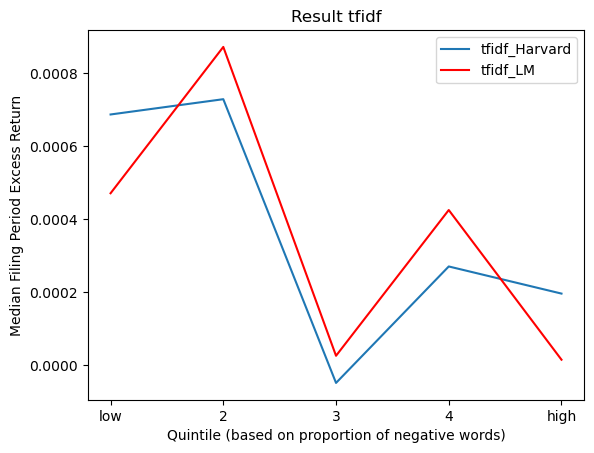

In [160]:
# Graph
import matplotlib.pyplot as plt

x_axis = ['low', 2, 3, 4, 'high']
# Plotting
# plt.plot(x_axis, result_tfidf_LM, label='tfidf_LM')
# plt.plot(x_axis, result_pro_LM, label='pro_LM')
plt.plot(x_axis, result_tfidf_H, label='tfidf_Harvard')
plt.plot(x_axis, result_tfidf_LM, color = "red", label='tfidf_LM')

# Adding labels and title
plt.xlabel('Quintile (based on proportion of negative words)')
plt.ylabel('Median Filing Period Excess Return')
plt.title('Result tfidf')
plt.legend()  # Show legend

# Display the plot
plt.show()

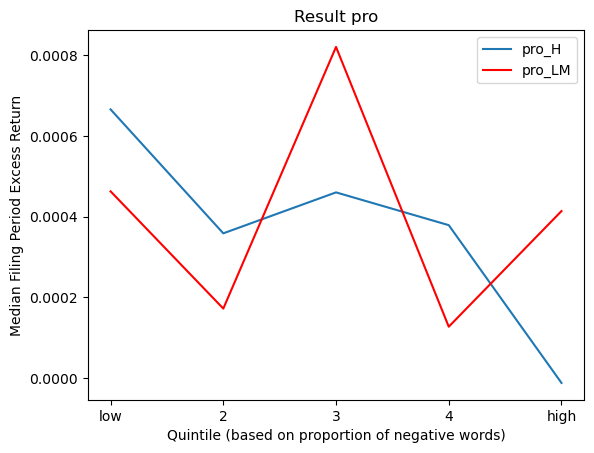

In [161]:
import matplotlib.pyplot as plt

x_axis = ['low', 2, 3, 4, 'high']
# Plotting
# plt.plot(x_axis, result_tfidf_LM, label='tfidf_LM')
# plt.plot(x_axis, result_pro_LM, label='pro_LM')
plt.plot(x_axis, result_pro_H, label='pro_H')
plt.plot(x_axis, result_pro_LM, color="red", label='pro_LM')


# Adding labels and title
plt.xlabel('Quintile (based on proportion of negative words)')
plt.ylabel('Median Filing Period Excess Return')
plt.title('Result pro')
plt.legend()  # Show legend

# Display the plot
plt.show()

